In [1]:
import glob
import os
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.ticker as tck
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [2]:
def read_storge(rofdir, start_date, end_date, nlat, nlon, lats, lons):
    y1 = int(start_date[:4])
    y2 = int(end_date[:4])
    time = pd.date_range(
        str(y1) + "-01-01",
        str(y2) + "-12-31",
        freq="D",
    )
    leapday_idx = (time.month == 2) & (time.day == 29)
    time = time[~leapday_idx]
    list_store = []
    for year in range(y1, y2 + 1):
        # print('processing', year)
        qfile = rofdir + "storge%i.bin" % year
        if not os.path.isfile(qfile):
            print("doesn't exist", qfile)
            continue
        outflw = np.fromfile(qfile, "<f").reshape(-1, nlat, nlon)
        outflw[outflw > 1.0e19] = 0
        list_store.append(outflw)
    store = xr.DataArray(
        np.vstack(list_store),
        dims=("time", "lat", "lon"),
        coords={"time": time, "lat": lats, "lon": lons},
    )
    return store

def read_outflw(rofdir, start_date, end_date, nlat, nlon, lats, lons):
    y1 = int(start_date[:4])
    y2 = int(end_date[:4])
    time = pd.date_range(
        str(y1) + "-01-01",
        str(y2) + "-12-31",
        freq="D",
    )
    leapday_idx = (time.month == 2) & (time.day == 29)
    time = time[~leapday_idx]
    list_outflw = []
    for year in range(y1, y2 + 1):
        # print('processing', year)
        qfile = rofdir + "outflw%i.bin" % year
        if not os.path.isfile(qfile):
            print("doesn't exist", qfile)
            continue
        outflw = np.fromfile(qfile, "<f").reshape(-1, nlat, nlon)
        outflw[outflw > 1.0e19] = 0
        list_outflw.append(outflw)
    outflw = xr.DataArray(
        np.vstack(list_outflw),
        dims=("time", "lat", "lon"),
        coords={"time": time, "lat": lats, "lon": lons},
    )
    return outflw

def get_gridcell_stations(sel_daminfo, qsim_grid):
    tmp = {}
    for idx, row in sel_daminfo.iterrows():
        xi0, yj0 = row.drt_pxi0, row.drt_pyj0
        qsim_sti = qsim_grid.isel(lat=yj0, lon=xi0)
        qsim_sti = qsim_sti.reset_coords(("lat", "lon"), drop=True)
        tmp[str(idx)] = qsim_sti
    mdl = xr.Dataset(tmp)
    return mdl

def get_gridcell_reservoir(sel_daminfo, sim, res_extent):
    tmp = {}
    res_extent_grd = res_extent.stack(ngrd=("lat", "lon"))
    sim_grd = sim.stack(ngrd=("lat", "lon"))
    for idx, row in sel_daminfo.iterrows():
        ma = np.where(res_extent_grd == idx)[0]
        sim_res = sim_grd.isel(ngrd=ma).sum("ngrd")  # /1.223e3 # m3 to acre-ft
        tmp[str(idx)] = sim_res
    sim_store = xr.Dataset(tmp)
    return sim_store

In [3]:
camadir = "/glade/work/elkoukah/empirical/reservoirs/cama400/"

exp = 'fullDams'

daminfo_file = camadir + f"my_dams_setup/pxpy_qmax_my_dam_list_sw_{exp[:-4]}.xlsx"
daminfo = pd.read_excel(daminfo_file, index_col="ID")


df_resopus = pd.read_csv('/glade/work/elkoukah/inputs/obs/ResOpsUS/ResOpsUS/attributes/reservoir_attributes.csv')

damspecs = pd.read_csv(f'/glade/derecho/scratch/elkoukah/inputs/CFD/SW4km-opt_{exp}_1980-2020_399x299/spec/dam_info_istarf_final_irr_usgs.csv', 
                       index_col="ID")

In [4]:
ma = daminfo.reset_index()['ID'].isin(df_resopus['DAM_ID'])
daminfo_obs = daminfo[ma.values]

In [5]:
obsdir = '/glade/work/elkoukah/inputs/obs/ResOpsUS/ResOpsUS/time_series_all/'

obs_release = xr.Dataset()
obs_storage = xr.Dataset()

for damid in daminfo_obs.index:
    # print(damid)
    data = pd.read_csv(obsdir+f'ResOpsUS_{damid}.csv')
    time = data["date"].values.astype("datetime64[D]")
    da_s = xr.DataArray(data['storage'].values.astype(float), dims=("time"), coords={"time": time})
    da_r = xr.DataArray(data['outflow'].values.astype(float), dims=("time"), coords={"time": time})
    obs_release[str(damid)] = da_r
    obs_storage[str(damid)] = da_s

In [6]:
# Eval period
start_date = "1980-01-01"
end_date = "2020-12-31"

In [7]:
res = 0.05
x0 = -124.950
x1 = -105.000
y0 = 30.000
y1 = 44.950
lats = np.arange(y0 + res / 2, y1, res)[::-1]
lons = np.arange(x0 + res / 2, x1, res)
nlat, nlon = lats.size, lons.size

res_extent_file = f"/glade/derecho/scratch/elkoukah/inputs/CFD/SW4km-opt_{exp}_1980-2020_399x299/bin/dam_reservoir_map/reservoir_extent_399x299.int"
res_extent = np.fromfile(res_extent_file, "i4")
res_extent = xr.DataArray(res_extent.reshape(nlat, nlon),dims=("lat", "lon"),coords={"lat": lats, "lon": lons},)
archivedir = "/glade/derecho/scratch/elkoukah/archive/"

In [8]:
# opt, empirical, cu,
caseid_dam = "prod_swna_4km_new_surfdata_conus404.opt_001"
# rofdir_dam = archivedir + caseid_dam + f"/rof/DAM_generic_nocu_{exp}/"
# rofdir_dam = archivedir + caseid_dam + f"/rof/DAM_empirical_nocu_{exp}/"
# rofdir_dam = archivedir + caseid_dam + f"/rof/DAM_generic_irrUSGS_{exp}/"
# rofdir_dam = archivedir + caseid_dam + f"/rof/DAM_empirical_irrUSGS_{exp}/"
rofdir_dam = archivedir + caseid_dam + f"/rof/DAM_empirical_irrUSGS_{exp}_Isim/"
# rofdir_dam = archivedir + caseid_dam + "/rof/NAT_3min_1980-2020_fixlat/"

outflw_istarf_optcu = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
gridded_storage_istarf_optcu = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
qmdl_istarf_optcu = get_gridcell_stations(daminfo_obs, outflw_istarf_optcu)
storage_istarf_optcu = get_gridcell_reservoir(daminfo_obs, gridded_storage_istarf_optcu, res_extent)

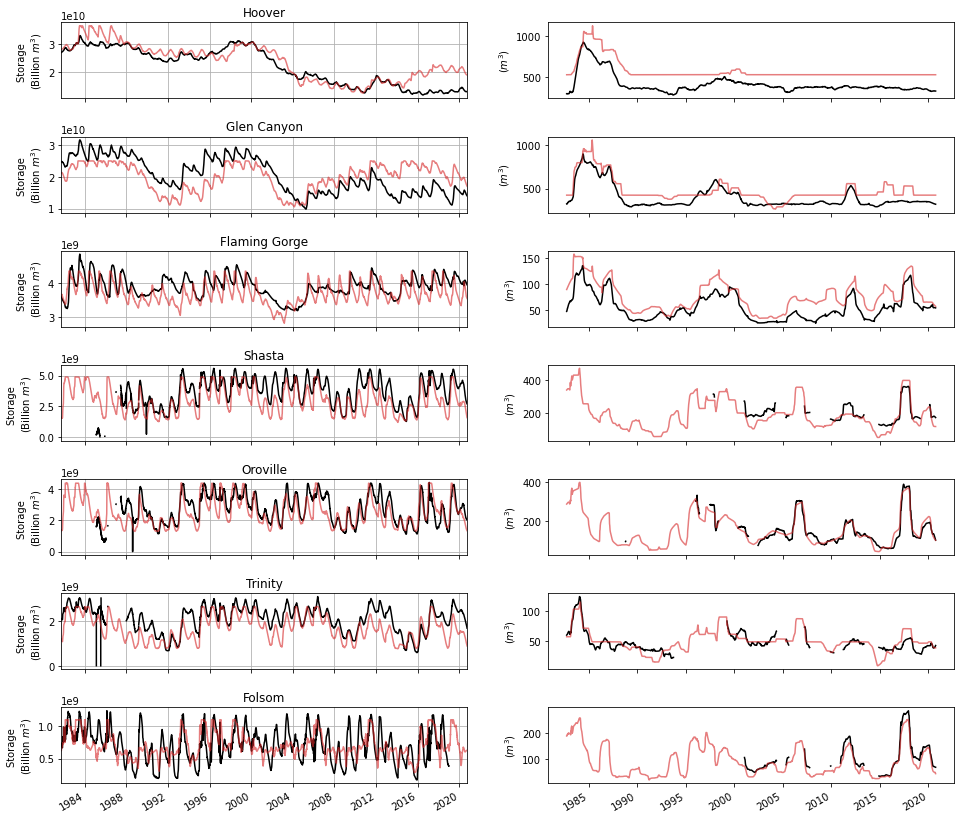

In [9]:
plot_tdelta = slice('1981-10-01', '2020-09-30')
sxx = obs_storage.sel(time=plot_tdelta)*10**6
syy = storage_istarf_optcu.sel(time=plot_tdelta)

rxx = obs_release.sel(time=plot_tdelta).rolling(time=365).mean()
ryy = qmdl_istarf_optcu.sel(time=plot_tdelta).rolling(time=365).mean()

damids = ['610','597','451','132','148','131','182']
fig, axes = plt.subplots(len(damids), 2, sharex="col", figsize=(16, 2*len(damids)))
plt.subplots_adjust(hspace=.5)
for i, damid in enumerate(damids):
    title = daminfo.loc[int(damid), 'Project name']
    ax = axes[i, 0]
    sxx[damid].plot(ax=ax, c="k", label="Observed (Reclamation)")
    syy[damid].plot(ax=ax, c="tab:red", alpha=.6, label="opt, empirical, cu")
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.margins(x=0)
    ax.set_ylabel("Storage \n(Billion $m^3$)")
    ax.set_title(title, loc="center")
    ax.grid()
    
    ax = axes[i, 1]
    rxx[damid].plot(ax=ax, c="k", label="Observed (Reclamation)")
    ryy[damid].plot(ax=ax, c="tab:red", alpha=.6, label="opt, empirical, cu")
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_ylabel(" \n($m^3$)")

In [60]:
rxx['597'].mean(), ryy['597'].mean(), 
# rxx['597'].sel(time=slice('2000','2020')).mean(), ryy['597'].sel(time=slice('2000','2020')).mean(), 

(<xarray.DataArray '597' ()>
 array(395.97408501),
 <xarray.DataArray '597' ()>
 array(475.38544, dtype=float32))

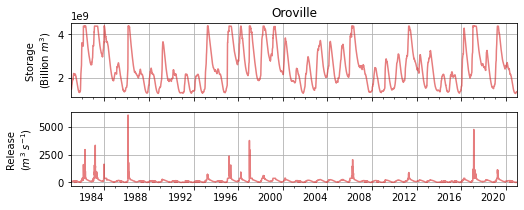

In [21]:
plot_tdelta = slice('1981-01-01', '2020-12-31')
sxx = obs_storage.sel(time=plot_tdelta)*10**6
syy = storage_istarf_optcu.sel(time=plot_tdelta)

rxx = obs_release.sel(time=plot_tdelta)
ryy = qmdl_istarf_optcu.sel(time=plot_tdelta)

damid = '148'

title = daminfo.loc[int(damid), 'Project name']

fig, axes = plt.subplots(2, 1, sharex="col", figsize=(8, 3))
ax = axes[0]
# sxx[damid].plot(ax=ax, c="k", label="Observed (Reclamation)")
syy[damid].plot(ax=ax, c="tab:red", alpha=.6, label="opt, empirical, cu")
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.margins(x=0)
ax.set_ylabel("Storage \n(Billion $m^3$)")
ax.set_title(title, loc="center")
ax.grid()

ax = axes[1]
# rxx[damid].plot(ax=ax, c="k", label="Observed (Reclamation)")
ryy[damid].plot(ax=ax, c="tab:red", alpha=.6, label="opt, empirical, cu")
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.margins(x=0)
ax.set_ylabel("Release \n($m^3\;s^{-1}$)")
ax.grid()
ax.tick_params(axis="x", labelrotation=0,)
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())

In [17]:
# Lake Powell inflows
damid = 597
indir_obs = "/glade/work/elkoukah/inputs/obs/usbr/hydrodata/reservoir_data/"
release_file = indir_obs + "919/csv/29.csv"
df = pd.read_csv(release_file)
time = df["datetime"].values.astype("datetime64[D]")
data = df["inflow"].values.astype(float) * 0.02832  # cfs to cms
obs_inflow = xr.DataArray(data, dims=("time"), coords={"time": time})

In [18]:
mapdir = "/glade/work/elkoukah/empirical/reservoirs/cama400/map/SW_3min/"
nextxy = np.fromfile(mapdir+'nextxy.bin', '<i').reshape(-1,nlat,nlon)
nextx, nexty = nextxy
res_data = res_extent.data
res_datar = res_data.ravel()
sim_grd = outflw_istarf_optcu.sel(time='1983').mean('time').data.ravel()

# idx = 597
idx = 610
list_gi = []
for gi,i,j in zip(np.arange(res_datar.size), nextx.ravel(), nexty.ravel()):
    if (i>=0 and j>=0):
        if (res_data[j-1,i-1] == idx) and (res_datar[gi] == 0):
            print(idx, gi, sim_grd[gi])
            list_gi.append(gi)

597 54562 677.9954
597 54954 15.413621
597 54955 0.15801448
597 54958 0.034658052
597 54959 0.039065883
597 55354 0.038728893
597 55361 0.019005444
597 55750 0.18329054
597 55755 0.073610224
597 55759 0.6322543
597 56150 0.007499706
597 56152 0.05449024
597 56156 0.020441974
597 56157 0.098215975
597 56547 0.49656135
597 56555 0.03704831
597 56945 0.12381906
597 56950 1.3088137
597 56953 0.12753022
597 56954 2.0977786
597 57344 0.02841842
597 57349 0.021465495
597 57743 0.025668785
597 57748 0.015399404
597 58136 0.031242933
597 58137 0.7635789
597 58138 0.013722064
597 58139 0.2013319
597 58140 0.015945785
597 58146 0.51965743
597 58535 0.41415682
597 58539 0.031842675
597 58543 0.13103732
597 58933 0.019213641
597 59340 0.015845455
597 59341 0.031898692
597 59730 7.28553
597 59731 0.060859807
597 59732 0.021062428
597 59739 0.16016412
597 60128 0.19198795
597 60132 0.026503075
597 60137 0.014441817
597 60527 0.008171282
597 60531 0.0065210494
597 60535 0.013761904
597 60541 0.0181455

In [19]:
# gi = 73248 #lake mead inflow point
# gi = 54562 #lake powell inflow point
sim_outflow = outflw_istarf_optcu.stack(ngrd=('lat','lon')).isel(ngrd=[73248]).sum('ngrd')
# sim_outflow = outflw_istarf_optcu.stack(ngrd=('lat','lon')).isel(ngrd=list_gi).sum('ngrd')
yy = sim_outflow.sel(time=plot_tdelta)#.resample(time='M').mean()
xx = obs_inflow.sel(time=plot_tdelta)#.resample(time='M').mean()

In [49]:
print(yy.mean())
print(xx.mean())

<xarray.DataArray ()>
array(533.303, dtype=float32)
<xarray.DataArray ()>
array(405.84114228)


In [104]:
ifile = '/glade/derecho/scratch/elkoukah/inputs/CFD/SW4km-opt_fullDams_1980-2020_399x299/bin/dam_reservoir_map/dam_location_399x299.int'
dam_location = np.fromfile(ifile, '<i').reshape(-1,nlat,nlon)[0]
dam_grids = dam_location.ravel()

idx = 597
list_gi = []
for gi,i,j in zip(np.arange(dam_grids.size), nextx.ravel(), nexty.ravel()):
    if (i>=0 and j>=0):
        if (dam_location[j-1,i-1] == idx):
            print(idx, gi, sim_grd[gi])
            list_gi.append(gi)

597 63710 827.9277


In [105]:
Imean_tdelta = slice('1999-10-01', '2020-09-30')
# gi = [70826]
gi = list_gi
sim_outflow = outflw_istarf_optcu.stack(ngrd=('lat','lon')).isel(ngrd=gi).sum('ngrd')
yy = sim_outflow.sel(time=Imean_tdelta)#.resample(time='M').mean()
xx = obs_inflow.sel(time=Imean_tdelta)#.resample(time='M').mean()
print(yy.mean())
print(xx.mean())

<xarray.DataArray ()>
array(424.9758, dtype=float32)
<xarray.DataArray ()>
array(333.98035646)


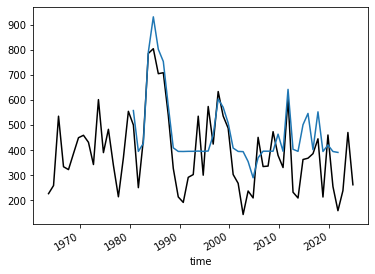

In [92]:
obs_inflow.resample(time='A-SEP').mean().plot(c='k')
sim_outflow.resample(time='A-SEP').mean().plot()

Text(0, 0.5, 'Inflow ($m^3\\;s^{-1}$)')

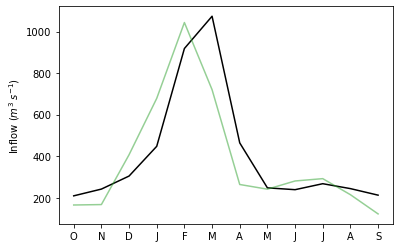

In [74]:
sim_outflow = outflw_istarf_optcu.stack(ngrd=('lat','lon')).isel(ngrd=[54562]).sum('ngrd')
yy = sim_outflow.sel(time=plot_tdelta)#.resample(time='M').mean()
xx = obs_inflow.sel(time=plot_tdelta)#.resample(time='M').mean()
time = xx.time
ma = (time.dt.month==2)&(time.dt.day==29)
xx = xx[~ma]

xx_annc = xx.groupby("time.month").mean()
yy_annc = yy.groupby('time.month').mean()

fig, ax1 = plt.subplots(1, 1)
ax1.plot(xx_annc.data, c='k', label='Observed (Reclamation)')
ax1.plot(yy_annc.data, color='tab:green', alpha=.5, label='Simulated (Empirical policies + Use)')
ax1.set_xticks(range(12));
ax1.set_xticklabels(['O','N','D', 'J','F','M','A','M','J','J','A','S',]);
ax1.set_ylabel('Inflow ($m^3\;s^{-1}$)')

In [106]:
# plot simulations

In [27]:
# ref, generic, ncou
caseid_dam = "prod_swna_4km_new_surfdata_conus404.ref_001"
rofdir_dam = archivedir + caseid_dam + f"/rof/DAM_generic_nocu_{exp}/"
flw_ref_generic_nocu_grid = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
store_ref_generic_nocu_grid = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
flw_ref_generic_nocu = get_gridcell_stations(daminfo_obs, flw_ref_generic_nocu_grid)
store_ref_generic_nocu = get_gridcell_reservoir(daminfo_obs, store_ref_generic_nocu_grid, res_extent)

In [28]:
# ref, empirical, ncou
caseid_dam = "prod_swna_4km_new_surfdata_conus404.ref_001"
rofdir_dam = archivedir + caseid_dam + f"/rof/DAM_empirical_nocu_{exp}/"
flw_ref_empirical_nocu_grid = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
store_ref_empirical_nocu_grid = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
flw_ref_empirical_nocu = get_gridcell_stations(daminfo_obs, flw_ref_empirical_nocu_grid)
store_ref_empirical_nocu = get_gridcell_reservoir(daminfo_obs, store_ref_empirical_nocu_grid, res_extent)

In [29]:
# opt, generic, ncou
caseid_dam = "prod_swna_4km_new_surfdata_conus404.opt_001"
rofdir_dam = archivedir + caseid_dam + f"/rof/DAM_generic_nocu_{exp}/"
flw_opt_generic_nocu_grid = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
store_opt_generic_nocu_grid = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
flw_opt_generic_nocu = get_gridcell_stations(daminfo_obs, flw_opt_generic_nocu_grid)
store_opt_generic_nocu = get_gridcell_reservoir(daminfo_obs, store_opt_generic_nocu_grid, res_extent)

In [30]:
# opt, empirical, ncou
caseid_dam = "prod_swna_4km_new_surfdata_conus404.opt_001"
rofdir_dam = archivedir + caseid_dam + f"/rof/DAM_empirical_nocu_{exp}/"
flw_opt_empirical_nocu_grid = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
store_opt_empirical_nocu_grid = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
flw_opt_empirical_nocu = get_gridcell_stations(daminfo_obs, flw_opt_empirical_nocu_grid)
store_opt_empirical_nocu = get_gridcell_reservoir(daminfo_obs, store_opt_empirical_nocu_grid, res_extent)

In [31]:
# opt, empirical, cu
caseid_dam = "prod_swna_4km_new_surfdata_conus404.opt_001"
rofdir_dam = archivedir + caseid_dam + f"/rof/DAM_empirical_irrUSGS_{exp}_Isim/"
flw_opt_empirical_cu_grid = read_outflw(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
store_opt_empirical_cu_grid = read_storge(rofdir_dam, start_date, end_date, nlat, nlon, lats, lons)
flw_opt_empirical_cu = get_gridcell_stations(daminfo_obs, flw_opt_empirical_cu_grid)
store_opt_empirical_cu = get_gridcell_reservoir(daminfo_obs, store_opt_empirical_cu_grid, res_extent)

In [9]:
# save
# dict_out = {'obs':{'storage':obs_storage, 'release':obs_release},
#             'ref':{'storage':{'generic':store_ref_generic_nocu,
#                               'empirical':store_ref_empirical_nocu},
#                    'release':{'generic':flw_ref_generic_nocu,
#                               'empirical':flw_ref_empirical_nocu,}},
#             'opt':{'storage':{'generic':store_opt_generic_nocu,
#                               'empirical':store_opt_empirical_nocu,
#                               'empirical_cu':store_opt_empirical_cu},
#                    'release':{'generic':flw_opt_generic_nocu,
#                               'empirical':flw_opt_empirical_nocu,
#                               'empirical_cu':flw_opt_empirical_cu}}
# }
# pickle.dump(dict_out, open('out/dam_obs_sim.pkl', 'wb'))

In [8]:
dams_data = pickle.load(open('out/dam_obs_sim.pkl', 'rb'))

In [9]:
obs_storage = dams_data['obs']['storage']
store_ref_generic_nocu = dams_data['ref']['storage']['generic']
store_opt_generic_nocu = dams_data['opt']['storage']['generic']
store_ref_empirical_nocu = dams_data['ref']['storage']['empirical']
store_opt_empirical_nocu = dams_data['opt']['storage']['empirical']
store_opt_empirical_cu = dams_data['opt']['storage']['empirical_cu']

obs_release = dams_data['obs']['release']
flw_ref_generic_nocu = dams_data['ref']['release']['generic']
flw_opt_generic_nocu = dams_data['opt']['release']['generic']
flw_ref_empirical_nocu = dams_data['ref']['release']['empirical']
flw_opt_empirical_nocu = dams_data['opt']['release']['empirical']
flw_opt_empirical_cu = dams_data['opt']['release']['empirical_cu']

In [10]:
# Fig for manuscript

In [11]:
plot_tdelta = slice('1981-10-01', '2020-09-30')
sxx = obs_storage.sel(time=plot_tdelta)*10**6
syy0 = store_ref_generic_nocu.sel(time=plot_tdelta)
syy1 = store_opt_generic_nocu.sel(time=plot_tdelta)
syy2 = store_ref_empirical_nocu.sel(time=plot_tdelta)
syy3 = store_opt_empirical_nocu.sel(time=plot_tdelta)
syy4 = store_opt_empirical_cu.sel(time=plot_tdelta)

rxx = obs_release.sel(time=plot_tdelta)
ryy0 = flw_ref_generic_nocu.sel(time=plot_tdelta)
ryy1 = flw_opt_generic_nocu.sel(time=plot_tdelta)
ryy2 = flw_ref_empirical_nocu.sel(time=plot_tdelta)
ryy3 = flw_opt_empirical_nocu.sel(time=plot_tdelta)
ryy4 = flw_opt_empirical_cu.sel(time=plot_tdelta)

In [12]:
roll = 90
rxx_roll = rxx.rolling(time=roll).mean()
ryy0_roll = ryy0.rolling(time=roll).mean()
ryy1_roll = ryy1.rolling(time=roll).mean()
ryy2_roll = ryy2.rolling(time=roll).mean()
ryy3_roll = ryy3.rolling(time=roll).mean()
ryy4_roll = ryy4.rolling(time=roll).mean()

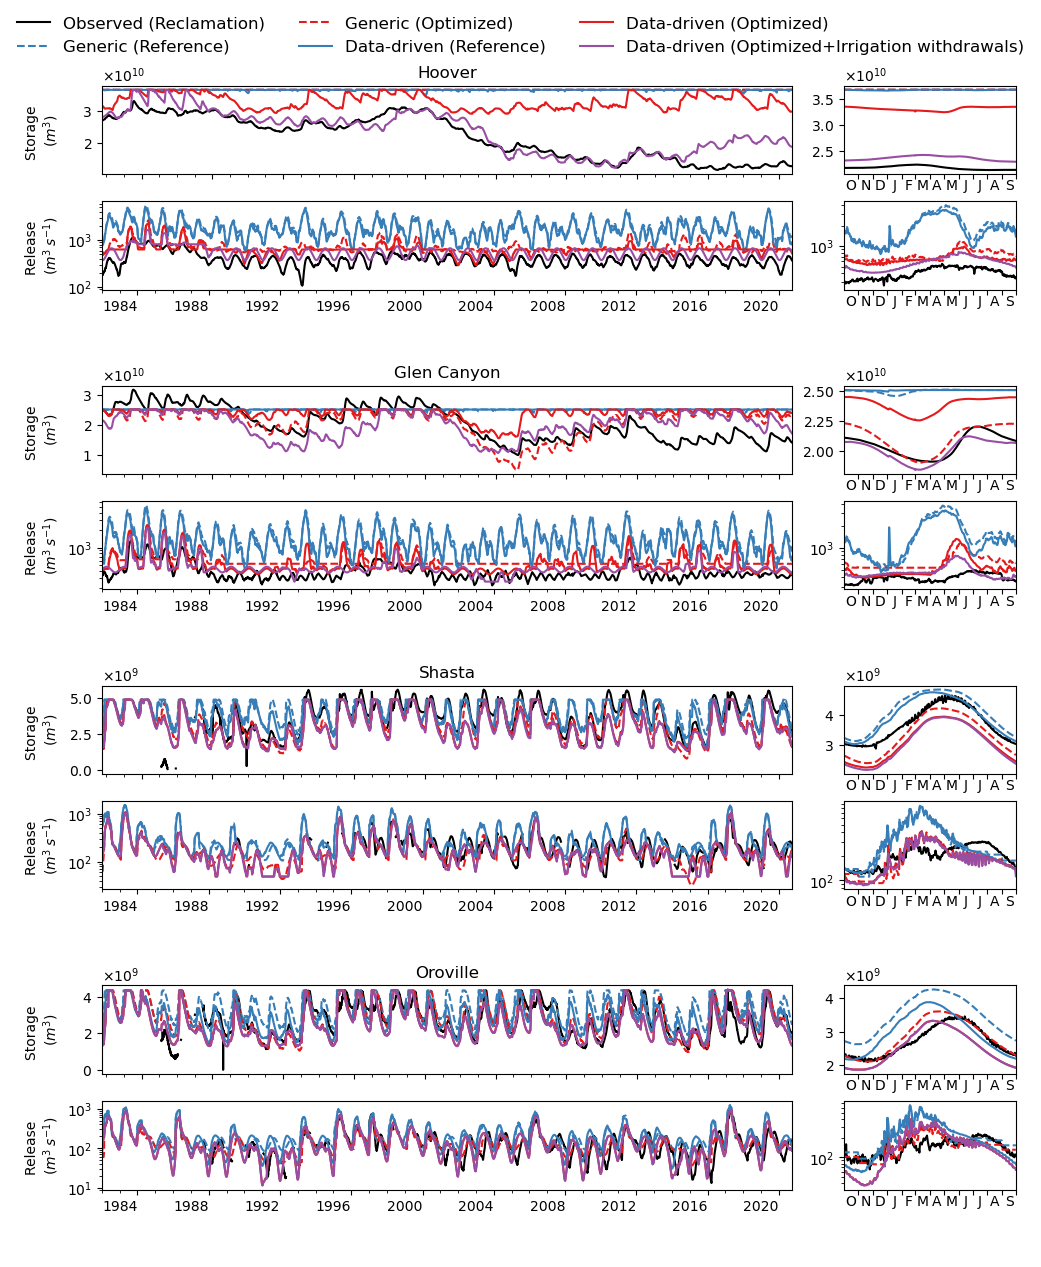

In [15]:
t = np.arange(365)
ti = np.hstack([t[273:],t[:273]])
monthlength = np.array([31,30,31, 31,28,31,30,31,30,31,31,30])

# damids = ['610','597','451','132','148','198']
damids = ['610','597','132','148']
c = ['#e41a1c', '#377eb8', '#984ea3']

ndam = len(damids)
hr = [1,1,.4]*int(ndam)
wr = [1,.25,1,.25]
fig, axes_all = plt.subplots(int(ndam*3), 2, figsize=(10, int(3*ndam)), 
                             layout="constrained",gridspec_kw={'height_ratios':hr[:], 'width_ratios':wr[:2]}, dpi=100)
axes = axes_all
axes1 = axes[::3]
axes2 = axes[1::3]
for ax in axes_all[2::3].ravel():
    ax.axis('off')

for i, damid in enumerate(damids):
    # storage
    ax = axes1[i,0]
    sxx[damid].plot(ax=ax, c="k", label="Observed (Reclamation)")
    syy0[damid].plot(ax=ax, c=c[1], ls='--', label="Generic (Reference)")
    syy1[damid].plot(ax=ax, c=c[0], ls='--', label="Generic (Optimized)")
    syy2[damid].plot(ax=ax, c=c[1], label="Data-driven (Reference)")
    syy3[damid].plot(ax=ax, c=c[0], label="Data-driven (Optimized)")
    syy4[damid].plot(ax=ax, c=c[2], label="Data-driven (Optimized+Irrigation withdrawals)")
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.margins(x=0)
    ax.set_ylabel("Storage \n($m^3$)")
    title = daminfo.loc[int(damid), 'Project name']
    ax.set_title(title, loc="center")
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.set_xticklabels([])
    ax.ticklabel_format(axis='y', useMathText=True)
    #
    ax = axes1[i,1]
    ax.plot(sxx[damid].groupby('time.dayofyear').mean().data[ti], c="k", label="Observed (Reclamation)")
    ax.plot(syy0[damid].groupby('time.dayofyear').mean().data[ti], c=c[1], ls='--', label="opt, empirical, cu")
    ax.plot(syy1[damid].groupby('time.dayofyear').mean().data[ti], c=c[0], ls='--', label="opt, empirical, cu")
    ax.plot(syy2[damid].groupby('time.dayofyear').mean().data[ti], c=c[1], label="opt, empirical, cu")
    ax.plot(syy3[damid].groupby('time.dayofyear').mean().data[ti], c=c[0], label="opt, empirical, cu")
    ax.plot(syy4[damid].groupby('time.dayofyear').mean().data[ti], c=c[2], label="opt, empirical, cu")
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.margins(x=0)
    ax.ticklabel_format(axis='y', useMathText=True)
    ax.set_xticks(np.cumsum(monthlength))
    ax.set_xticklabels('')
    ax.set_xticks((monthlength*1.0/2.)+np.cumsum(np.append(0,monthlength)[0:12]), minor=True)
    ax.set_xticklabels(['O','N','D', 'J','F','M','A','M','J','J','A','S',], minor=True);
    ax.tick_params('x',which='minor',length=0)

    # release
    ax = axes2[i,0]
    rxx_roll[damid].plot(ax=ax, c="k", label="Observed (Reclamation)")
    ryy0_roll[damid].plot(ax=ax, c=c[1], ls='--', label="opt, empirical, cu")
    ryy1_roll[damid].plot(ax=ax, c=c[0], ls='--', label="opt, empirical, cu")
    ryy2_roll[damid].plot(ax=ax, c=c[1], label="opt, empirical, cu")
    ryy3_roll[damid].plot(ax=ax, c=c[0], label="opt, empirical, cu")
    ryy4_roll[damid].plot(ax=ax, c=c[2], label="opt, empirical, cu")
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.margins(x=0)
    ax.set_ylabel("Release \n($m^3\;s^{-1}$)")
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.tick_params(axis="x",labelrotation=0,)
    ax.ticklabel_format(axis='y', useMathText=True)
    ax.set_yscale('log')
    #
    ax = axes2[i,1]
    ax.plot(rxx[damid].groupby('time.dayofyear').mean().data[ti], c="k", label="Observed (Reclamation)")
    ax.plot(ryy0[damid].groupby('time.dayofyear').mean().data[ti], c=c[1], ls='--', label="opt, empirical, cu")
    ax.plot(ryy1[damid].groupby('time.dayofyear').mean().data[ti], c=c[0], ls='--', label="opt, empirical, cu")
    ax.plot(ryy2[damid].groupby('time.dayofyear').mean().data[ti], c=c[1], label="opt, empirical, cu")
    ax.plot(ryy3[damid].groupby('time.dayofyear').mean().data[ti], c=c[0], label="opt, empirical, cu")
    ax.plot(ryy4[damid].groupby('time.dayofyear').mean().data[ti], c=c[2], label="opt, empirical, cu")
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.margins(x=0)
    ax.ticklabel_format(axis='y', useMathText=True)
    ax.set_xticks(np.cumsum(monthlength))
    ax.set_xticklabels('')
    ax.set_xticks((monthlength*1.0/2.)+np.cumsum(np.append(0,monthlength)[0:12]), minor=True)
    ax.set_xticklabels(['O','N','D', 'J','F','M','A','M','J','J','A','S',], minor=True);
    ax.tick_params('x',which='minor',length=0)
    ax.set_yscale('log')
    # break
fig.align_ylabels(axes_all[:])
fig.legend(*axes[0,0].get_legend_handles_labels(),loc="upper center",bbox_to_anchor=(0.5, 1.05),ncol=3,fontsize=12, frameon=False)

In [16]:
fig.savefig('./figs/re_dam_sim_timeseries_major.png', dpi=600, bbox_inches='tight')

In [28]:
def calc_mkge(x,y):
    r2 = np.mean((y-y.mean())*(x-x.mean()))/(y.std()*x.std())
    beta = y.mean()/x.mean()
    beta_p = (y.mean()-x.mean())/x.std()
    sigma = y.std()/x.std()
    mkge = 1 - np.sqrt(((r2-1)**2 + (sigma-1)**2 + beta_p**2))
    return mkge, r2, beta_p, sigma, beta

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def sel_time(xx, yy):
    xx = xx.sel(time=yy.time).data
    yy = yy.data[~np.isnan(xx)]
    xx = xx[~np.isnan(xx)]
    # if xx.size>0:
        # xx, yy = moving_average(xx, 90), moving_average(yy, 90)
    return xx, yy

In [29]:
iterables = [['ref','opt'], ['generic','empirical'], ['storage','release'],['mkge', 'r2', 'beta_p', 'sigma', 'beta']]
index = pd.MultiIndex.from_product(iterables, names=['sim', 'operation', "variable", "metric"])
df_metrics = pd.DataFrame(np.full((daminfo_obs.shape[0], len(index)), np.nan), columns=index, index=daminfo_obs.index)

In [30]:
eval_tdelta = slice('1981-10-01', '2020-09-30')
for damid in daminfo_obs.index:
    # release
    xx0 = obs_release[str(damid)].sel(time=eval_tdelta)
    yy0 = flw_ref_generic_nocu[str(damid)].sel(time=eval_tdelta)
    yy1 = flw_opt_generic_nocu[str(damid)].sel(time=eval_tdelta)
    yy2 = flw_ref_empirical_nocu[str(damid)].sel(time=eval_tdelta)
    yy3 = flw_opt_empirical_nocu[str(damid)].sel(time=eval_tdelta)
    xx, yy0 = sel_time(xx0, yy0)
    _, yy1 = sel_time(xx0, yy1)
    _, yy2 = sel_time(xx0, yy2)
    _, yy3 = sel_time(xx0, yy3)
    if xx.size>0:
        df_metrics.loc[damid, ('ref', 'generic', 'release')] = calc_mkge(xx,yy0)
        df_metrics.loc[damid, ('opt', 'generic', 'release')] = calc_mkge(xx,yy1)
        df_metrics.loc[damid, ('ref', 'empirical', 'release')] = calc_mkge(xx,yy2)
        df_metrics.loc[damid, ('opt', 'empirical', 'release')] = calc_mkge(xx,yy3)
    # storage
    xx0 = obs_storage[str(damid)].sel(time=eval_tdelta)*10**6
    yy0 = store_ref_generic_nocu[str(damid)].sel(time=eval_tdelta)
    yy1 = store_opt_generic_nocu[str(damid)].sel(time=eval_tdelta)
    yy2 = store_ref_empirical_nocu[str(damid)].sel(time=eval_tdelta)
    yy3 = store_opt_empirical_nocu[str(damid)].sel(time=eval_tdelta)
    xx, yy0 = sel_time(xx0, yy0)
    _, yy1 = sel_time(xx0, yy1)
    _, yy2 = sel_time(xx0, yy2)
    _, yy3 = sel_time(xx0, yy3)
    if xx.size>0:
        df_metrics.loc[damid, ('ref', 'generic', 'storage')] = calc_mkge(xx,yy0)
        df_metrics.loc[damid, ('opt', 'generic', 'storage')] = calc_mkge(xx,yy1)
        df_metrics.loc[damid, ('ref', 'empirical', 'storage')] = calc_mkge(xx,yy2)
        df_metrics.loc[damid, ('opt', 'empirical', 'storage')] = calc_mkge(xx,yy3)

/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/IPython/core/async_helpers.py:78: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [53]:
# df_metrics.to_csv('./out/metrics_dam_sim_swna_roll90.csv')

In [19]:
l = df_metrics.isnull().loc[:, ('ref', 'generic', 'release')].sum(axis=1)
(l>0).sum()

35

In [10]:
df_metrics = pd.read_csv('./out/metrics_dam_sim_swna.csv', index_col=0, header=[0,1,2,3])

In [32]:
index = pd.MultiIndex.from_product([['storage', 'release'], ['mkge', 'r2', 'beta_p', 'sigma'], ['y', 'x', 'hue']], 
                                   names=['variable', 'metric', 'operation'])
n = df_metrics.shape[0]
df_plot = pd.DataFrame(np.full((n*4, len(index)), np.nan), columns=index)
hue = np.vstack([np.array(['Reference','Optimized'])]*n).T.ravel()
for v in ['storage', 'release']:
    for m in ['mkge', 'r2', 'beta_p', 'sigma']:
        # for o in ['generic', 'empirical']:
        data0 = df_metrics.loc[:, (['ref','opt'], 'generic', v, m)].values
        data1 = df_metrics.loc[:, (['ref','opt'], 'empirical', v, m)].values
        df_plot.loc[:n*2-1, (v, m, 'x')] = np.array(['Generic']*n*2)
        df_plot.loc[:n*2-1, (v, m, 'y')] = data0.T.ravel()
        df_plot.loc[:n*2-1, (v, m, 'hue')] = hue
        #
        df_plot.loc[n*2:, (v, m, 'x')] = np.array(['Data-driven']*n*2)
        df_plot.loc[n*2:, (v, m, 'y')] = data1.T.ravel()
        df_plot.loc[n*2:, (v, m, 'hue')] = hue

In [33]:
import matplotlib.gridspec as gridspec

In [34]:
plt.rcParams.update({'font.size': 10})

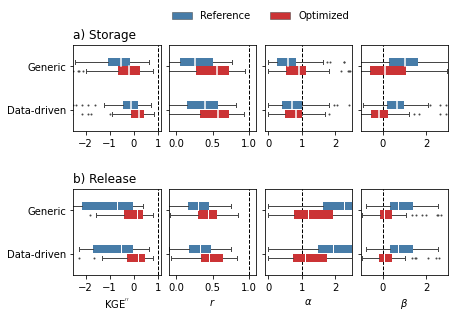

In [35]:
ylims = [(-2.5,1.1), (-.1,1.1), (-0.1,2.5), (-1,3)]
vlines = [1., 1., 1, 0.]
ylabels = [r"KGE$^{''}$", r"$r$", r"$\alpha$", r"$\beta$"]

fig = plt.figure(figsize=(6.5,4))
gs1 = gridspec.GridSpec(1,4)
gs1.update(left=0.1,right=0.9,top=0.9,bottom=0.6,wspace=0.1,hspace=0.25)
axes = []
for i,m in enumerate(('mkge','r2','sigma','beta_p')):
    ax = plt.subplot(gs1[0,i])
    axes.append(ax)
    sns.boxplot(ax=ax, data=df_plot, hue=('storage',m,'hue'), y=('storage',m,'x'), x=('storage',m,'y'),
                palette=['#377eb8', '#e41a1c'], width=.4, linewidth=1,
                boxprops=dict(linestyle='-', linewidth=0),
                medianprops={"color": "w", "linewidth": 1.5},
                flierprops=dict(marker='o', markersize=2, markeredgecolor='none'))
    ax.get_legend().remove()
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xlim(ylims[i])
    ax.axvline(vlines[i], lw=1, ls='--', c='k', zorder=-1)
    if i>0:
        ax.set_yticklabels(['', ''])
    else:
        ax.set_title('a) Storage', loc='left')
        ax.set_xticks([-2,-1,0,1])

gs2 = gridspec.GridSpec(1,4)
gs2.update(left=0.1,right=0.9,top=0.4,bottom=0.1,wspace=0.1,hspace=0.25)
for i,m in enumerate(('mkge','r2','sigma','beta_p')):
    ax = plt.subplot(gs2[0,i])
    axes.append(ax)
    sns.boxplot(ax=ax, data=df_plot, hue=('release',m,'hue'), y=('release',m,'x'), x=('release',m,'y'),
                palette=['#377eb8', '#e41a1c'], width=.4, linewidth=1,
                boxprops=dict(linestyle='-', linewidth=0),
                medianprops={"color": "w", "linewidth": 1},
                flierprops=dict(marker='o', markersize=2, markeredgecolor='none'))
    ax.get_legend().remove()
    ax.set_ylabel('')
    ax.set_xlabel(ylabels[i])
    ax.set_xlim(ylims[i])
    ax.axvline(vlines[i], lw=1, ls='--', c='k', zorder=-1)
    if i>0:
        ax.set_yticklabels(['', ''])
    else:
        ax.set_title('b) Release', loc='left')
        ax.set_xticks([-2,-1,0,1])

axes[2].set_xticks([0,1,2])
axes[6].set_xticks([0,1,2])
axes[1].set_xticks([0,.5,1])
axes[5].set_xticks([0,.5,1])

fig.legend(*ax.get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(.5,1.05), ncol=2, frameon=False)

In [52]:
fig.savefig('./figs/re_dam_sim_boxplots.png', dpi=600, bbox_inches='tight')

In [36]:
# rank-sum test
from scipy.stats import ranksums

In [42]:
sample1 = df_metrics.loc[:, ('opt', 'generic', 'storage', 'mkge')].dropna()
sample2 = df_metrics.loc[:, ('opt', 'empirical', 'storage', 'mkge')].dropna()
ranksums(sample1, sample2)

RanksumsResult(statistic=-4.094142187663662, pvalue=4.237342292828544e-05)

In [49]:
sample1 = df_metrics.loc[:, ('opt', 'generic', 'release', 'mkge')].dropna()
sample2 = df_metrics.loc[:, ('opt', 'empirical', 'release', 'mkge')].dropna()
ranksums(sample1, sample2)

RanksumsResult(statistic=-0.8411586223768435, pvalue=0.4002590774602458)